# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [3]:
import pymatching

# Initialize simulator

In [4]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2023-10-27'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Get IQ data

In [5]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 8871/8871 [00:03<00:00, 2852.17it/s]


# Pickle for other applications

In [6]:
import pickle

with open('IQ_data.pkl', 'wb') as f:
    pickle.dump(IQ_data, f)

with open('IQ_data_extreme.pkl', 'wb') as f:
    pickle.dump(IQ_data_extreme, f)

with open('qubit_mapping.pkl', 'wb') as f:
    pickle.dump(simulator.qubit_mapping, f)

with open('stim_circ.pkl', 'wb') as f:
    pickle.dump(simulator.stim_circ, f)

# Simulator

# Decode IQ data

In [7]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [18]:
import cpp_soft_info
from Scratch import load_calibration_memory

bandwiths = [0.4]*127
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwiths)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


# Using cpp kde

In [9]:
_DETAILED = False



matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_extreme = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors IQ EXTREME:", result_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors IQ: 131 out of 10000 shots for _RESETS = True
num_errors IQ EXTREME: 108 out of 10000 shots for _RESETS = True


In [19]:
relError = -1
absError = -1

relError = 1
# absError = 10

result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError)

result_extreme_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data_extreme, ROUNDS, int(LOGICAL), _RESETS,
                                            simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors KDE EXTREME:", result_extreme_kde.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors KDE: 125 out of 10000 shots for _RESETS = True
num_errors KDE EXTREME: 159 out of 10000 shots for _RESETS = True


In [11]:
p_meas = -1
p_meas = 7e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

matching = pymatching.Matching.from_detector_error_model(model)
result_informed_extreme = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data_extreme[:],
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                             p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors informed EXTREME:", result_informed_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors informed: 200 out of 10000 shots for _RESETS = True
num_errors informed EXTREME: 358 out of 10000 shots for _RESETS = True


In [12]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)

matching = pymatching.Matching.from_detector_error_model(model)
result_flat_extreme = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data_extreme,
                                                         ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                                            simulator.processed_scaler_dict, _detailed=_DETAILED)

print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_flat_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 143 out of 10000 shots for _RESETS = True
num_errors EXTREME: 576 out of 10000 shots for _RESETS = True


# Plot the results

In [13]:
print("\nIQ:", result.indices, "\nkde:", sorted(result_kde.indices), "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)
print("\nIQ EXTREME:", result_extreme.indices, "\nkde EXTREME:", sorted(result_extreme_kde.indices), "\nFlat EXTREME:", result_flat_extreme.indices, "\nInformed EXTREME", result_informed_extreme.indices)


IQ: [42, 65, 616, 825, 934, 943, 948, 997, 1029, 1049, 1076, 1132, 1335, 1551, 1578, 1588, 1614, 1664, 1792, 1807, 1889, 1897, 1954, 2115, 2144, 2274, 2327, 2640, 2817, 2824, 2850, 2901, 3015, 3120, 3137, 3258, 3316, 3467, 3516, 3746, 3822, 3863, 3896, 3928, 3960, 4053, 4127, 4188, 4291, 4452, 4461, 4462, 4507, 4536, 4592, 4674, 4715, 4717, 4749, 4840, 4871, 4935, 5052, 5183, 5224, 5258, 5265, 5386, 5404, 5425, 5451, 5532, 5586, 5594, 5789, 5976, 6095, 6200, 6222, 6240, 6459, 6470, 6518, 6526, 6548, 6576, 6699, 6714, 6841, 6899, 6953, 6957, 7016, 7157, 7233, 7276, 7311, 7371, 7691, 7710, 7939, 7974, 8212, 8502, 8507, 8527, 8594, 8651, 8676, 8777, 8790, 8896, 8992, 9104, 9142, 9156, 9262, 9297, 9370, 9378, 9523, 9634, 9647, 9693, 9728, 9744, 9828, 9850, 9863, 9877, 9984] 
kde: [42, 65, 616, 825, 934, 943, 948, 997, 1029, 1049, 1076, 1335, 1551, 1578, 1588, 1614, 1664, 1792, 1807, 1889, 1897, 1954, 2115, 2144, 2274, 2327, 2640, 2824, 2850, 2901, 3015, 3120, 3137, 3258, 3316, 3467, 3516,

In [14]:
from soft_info import draw_matching_graph


index = 6196

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_kde
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----Third {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


----- First True decoding -----


IndexError: list index out of range

In [ ]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

print()

iq_not_in_kde = sorted(set(result.indices) - set(result_kde.indices))
print("indices that are in IQ but not in kde with len:", len(iq_not_in_kde))
print(iq_not_in_kde)
kde_not_in_iq = sorted(set(result_kde.indices) - set(result.indices))
print("indices that are in kde but not in IQ with len:", len(kde_not_in_iq))
print(kde_not_in_iq)

indices that are in informed but not in IQ with len: 115
[424, 454, 458, 576, 668, 764, 901, 1195, 1283, 1348, 1471, 1671, 1718, 1743, 1786, 2222, 2254, 2305, 2342, 2411, 2412, 2431, 2432, 2539, 2615, 2869, 3023, 3161, 3246, 3431, 3477, 3745, 3840, 3856, 4196, 4227, 4249, 4268, 4292, 4300, 4353, 4366, 4393, 4549, 4589, 4686, 4693, 4700, 4730, 4834, 4906, 4953, 5016, 5047, 5185, 5189, 5365, 5531, 5630, 5953, 5960, 6104, 6196, 6227, 6234, 6304, 6320, 6553, 6650, 6774, 6964, 7080, 7156, 7179, 7181, 7354, 7412, 7444, 7453, 7528, 7576, 7614, 7644, 7657, 7738, 8306, 8358, 8391, 8599, 8644, 8730, 8833, 8841, 8848, 8864, 8873, 8939, 8954, 8987, 8999, 9137, 9243, 9277, 9323, 9341, 9533, 9657, 9662, 9773, 9814, 9820, 9825, 9885, 9901, 9931]
indices that are in IQ but not in informed with len: 46
[616, 997, 1076, 1551, 1588, 1792, 1889, 2144, 2274, 2640, 3120, 3258, 3316, 3467, 3516, 3928, 4053, 4127, 4291, 4452, 4536, 4674, 4840, 4871, 4935, 5183, 5224, 5586, 5594, 6714, 6953, 7233, 7311, 7371, 

# Analyse specific shots

{'0000000 000001 001000 000000 001000 000000 000000 000000': 1}


100%|██████████| 133/133 [00:00<00:00, 1841064.13it/s]

mean time edge weight: 2.9037038783495692

[(0, -1), (3, 9), (17, 23), (24, 25), (33, 39), (34, 35)]
-----IQ-----


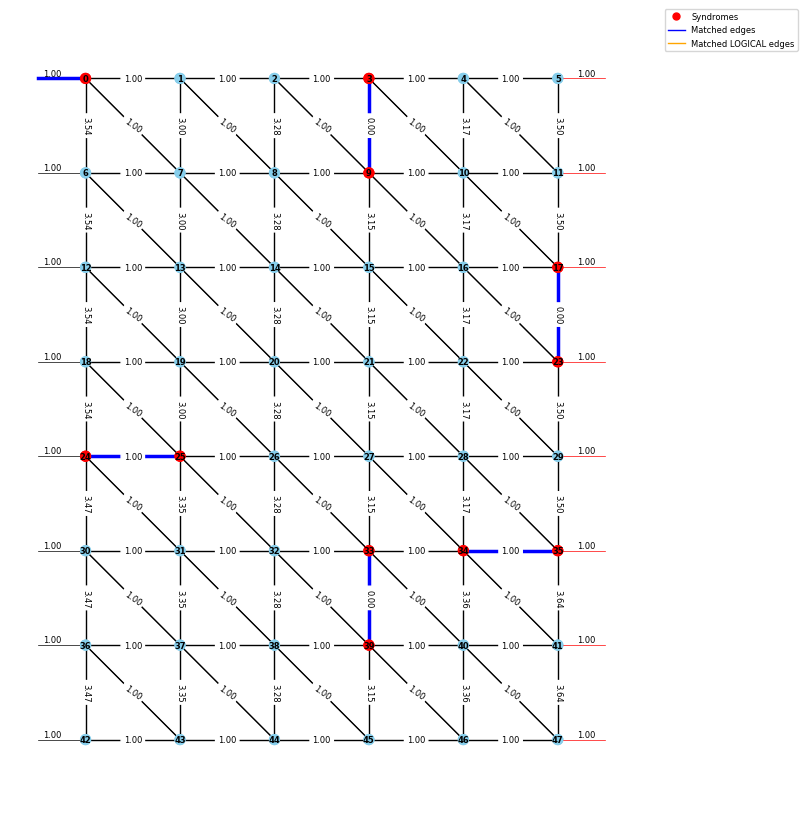

In [ ]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)